# Feature engineering, xgboost
https://www.kaggle.com/dlarionov/feature-engineering-xgboost


-　DateNum作成 'date_block_num',→YYYYMMで代用
- 祝日フラグ
- month
- days
- アイテムカテゴリ（デフォルト)-> カテゴリCategory、ジャンルType
- 月の売り上げ
- 月の売り上げラグ 1,2,3,6,12
- アイテムあたりの「週Or日」平均販売個数 1,2,3,6,12　　'date_item_avg_item_cnt_lag_1',
- ショップあたり「週Or日」平均販売個数ラグ1，2，3，6，12　　'date_shop_avg_item_cnt_lag_1',
- アイテムカテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12'date_cat_avg_item_cnt_lag_1',
- カテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12，'date_cat_avg_item_cnt_lag_1',
- ジャンル　あたり[月] 平均販売個数ラグ1,2,3,6,12
- アイテムカテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- カテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- ジャンル/ショップ　あたり[月] 平均販売個数ラグ1,2,3,6,12
- ASP　月当たり
- 価格下落率
- 最終販売日
- 初販売日
- ショップあたりの最終販売日
- ショップあたりの初販売日
    'delta_price_lag',


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
#category_names = pd.read_csv('./csv/category_names.csv')
#category_names.columns = ['ItemCategoryId', 'ItemCategoryName']

#item_categories = pd.read_csv('./csv/item_categories.csv')
#item_categories.columns = ['ItemId', 'ItemCategoryId']

#sales_history = pd.read_csv('./csv/sales_history.csv')
#sales_history.columns = ['Date', 'StoreId', 'ItemId', 'ItemPrice', 'SoldNum']
#sales_history['Date'] = pd.to_datetime(sales_history['Date'])

test = pd.read_csv('test.csv')
test.columns = ['index', 'ItemId', 'StoreId']
#item_categories['ItemCategoryId'].unique()
#category_names.query('ItemCategoryName.str.contains("")')
'''170品目のリスト'''
test_item = test['ItemId'].unique()
test_item = pd.DataFrame({'ItemId':test_item})

'''年月のリスト'''
#yyyymm = pd.read_csv('./csv/yyyymm.csv')

'''170品目と月番号加工済みデータ '''
target = pd.read_csv('./csv/sales_170filled_numeric.csv')

target

,date_block_num,YYYY,MM,StoreId,ItemId,ItemPrice,SoldNum,is_holiday,ItemCategoryId,Category,Type
0,0,2018,1,0,1000001,420.000000,6.0,0.0,100,5,1
1,1,2018,2,0,1000001,356.666667,3.0,0.0,100,5,1
2,2,2018,3,0,1000001,420.000000,1.0,0.0,100,5,1
3,3,2018,4,0,1000001,420.000000,2.0,0.0,100,5,1
4,4,2018,5,0,1000001,0.000000,0.0,0.0,100,5,1
...,...,...,...,...,...,...,...,...,...,...,...
67315,17,2019,6,17,3500001,0.000000,0.0,0.0,350,6,6
67316,18,2019,7,17,3500001,0.000000,0.0,0.0,350,6,6
67317,19,2019,8,17,3500001,0.000000,0.0,0.0,350,6,6
67318,20,2019,9,17,3500001,0.000000,0.0,0.0,350,6,6


In [3]:
#test_item
'''カテゴリ名と連結
#ttest = pd.merge(test,item_categories, on='ItemId')
#ttest = pd.merge(ttest, category_names,on='ItemCategoryId')
print('予測データの品目数: ',target['ItemId'].nunique(),'\n',
      '予測データのカテゴリ数: ',target['ItemCategoryId'].nunique(),'\n',
     '売上の総数: ',target['SoldNum'].sum(), '\n',
     '')'''

"カテゴリ名と連結\n#ttest = pd.merge(test,item_categories, on='ItemId')\n#ttest = pd.merge(ttest, category_names,on='ItemCategoryId')\nprint('予測データの品目数: ',target['ItemId'].nunique(),'\n',\n      '予測データのカテゴリ数: ',target['ItemCategoryId'].nunique(),'\n',\n     '売上の総数: ',target['SoldNum'].sum(), '\n',\n     '')"

# pivotせずに特徴量作成

In [4]:
#target.drop(['CatName','TypeName'],axis=1,inplace=True)
#target.to_csv('./csv/sales_170filled_numeric.csv')

# Lag関数

In [5]:
def lag_feature(df,lags,col):
    tmp = df[['date_block_num','StoreId','ItemId',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','StoreId','ItemId',col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df,shifted, on=['date_block_num','StoreId','ItemId'],how='left')
    return df

# 売上月次推移

In [6]:
ts = time.time()
matrix = lag_feature(target,[1,2,3,6,12],'SoldNum')
time.time() - ts

0.0723724365234375

In [7]:
matrix

,date_block_num,YYYY,MM,StoreId,ItemId,ItemPrice,SoldNum,is_holiday,ItemCategoryId,Category,Type,SoldNum_lag_1,SoldNum_lag_2,SoldNum_lag_3,SoldNum_lag_6,SoldNum_lag_12
0,0,2018,1,0,1000001,420.000000,6.0,0.0,100,5,1,NaN,NaN,NaN,NaN,NaN
1,1,2018,2,0,1000001,356.666667,3.0,0.0,100,5,1,6.0,NaN,NaN,NaN,NaN
2,2,2018,3,0,1000001,420.000000,1.0,0.0,100,5,1,3.0,6.0,NaN,NaN,NaN
3,3,2018,4,0,1000001,420.000000,2.0,0.0,100,5,1,1.0,3.0,6.0,NaN,NaN
4,4,2018,5,0,1000001,0.000000,0.0,0.0,100,5,1,2.0,1.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67315,17,2019,6,17,3500001,0.000000,0.0,0.0,350,6,6,0.0,0.0,0.0,1.0,0.0
67316,18,2019,7,17,3500001,0.000000,0.0,0.0,350,6,6,0.0,0.0,0.0,0.0,0.0
67317,19,2019,8,17,3500001,0.000000,0.0,0.0,350,6,6,0.0,0.0,0.0,0.0,0.0
67318,20,2019,9,17,3500001,0.000000,0.0,0.0,350,6,6,0.0,0.0,0.0,0.0,0.0


# 品目あたりの月平均売上個数

In [8]:
group = matrix.groupby(['date_block_num']).agg({'SoldNum':'mean'})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on='date_block_num',how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)

# 店舗あたりの月平均売上個数

In [9]:
group = matrix.groupby(['date_block_num','StoreId']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId'],how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)

# アイテムカテゴリあたりの月平均売上個数

In [10]:
group = matrix.groupby(['date_block_num','ItemCategoryId']).agg({'SoldNum':'mean'})
group.columns = ['date_itemcat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','ItemCategoryId'],how='left')
matrix['date_itemcat_avg_item_cnt'] = matrix['date_itemcat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_itemcat_avg_item_cnt')
matrix.drop(['date_itemcat_avg_item_cnt'],axis=1,inplace=True)

# カテゴリあたりの月平均売上個数

In [11]:
group = matrix.groupby(['date_block_num','Category']).agg({'SoldNum':'mean'})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','Category'],how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'],axis=1,inplace=True)

# ジャンルあたりの月平均売上個数

In [12]:
group = matrix.groupby(['date_block_num','Type']).agg({'SoldNum':'mean'})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','Type'],how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1,inplace=True)

# アイテムカテゴリ・ショップあたりの月平均売上個数

In [13]:
group = matrix.groupby(['date_block_num','StoreId','ItemCategoryId']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_itemcat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','ItemCategoryId'],how='left')
matrix['date_shop_itemcat_avg_item_cnt'] = matrix['date_shop_itemcat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_itemcat_avg_item_cnt')
matrix.drop(['date_shop_itemcat_avg_item_cnt'],axis=1,inplace=True)

# カテゴリ・ショップあたりの月平均売上個数

In [14]:
group = matrix.groupby(['date_block_num','StoreId','Category']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','Category'],how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'],axis=1,inplace=True)

# ジャンル・ショップあたりの月平均売上個数

In [15]:
group = matrix.groupby(['date_block_num','StoreId','Type']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','Type'],how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'],axis=1,inplace=True)

In [16]:
matrix.fillna(0)

,date_block_num,YYYY,MM,StoreId,ItemId,ItemPrice,SoldNum,is_holiday,ItemCategoryId,Category,...,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12
0,0,2018,1,0,1000001,420.000000,6.0,0.0,100,5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,2018,2,0,1000001,356.666667,3.0,0.0,100,5,...,1.666992,0.000000,0.000000,0.000000,0.000000,1.666992,0.000000,0.000000,0.0,0.0
2,2,2018,3,0,1000001,420.000000,1.0,0.0,100,5,...,0.888672,1.666992,0.000000,0.000000,0.000000,0.666504,1.666992,0.000000,0.0,0.0
3,3,2018,4,0,1000001,420.000000,2.0,0.0,100,5,...,0.666504,0.888672,1.666992,0.000000,0.000000,0.666504,0.666504,1.666992,0.0,0.0
4,4,2018,5,0,1000001,0.000000,0.0,0.0,100,5,...,0.592773,0.666504,0.888672,0.000000,0.000000,0.866699,0.666504,0.666504,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67315,17,2019,6,17,3500001,0.000000,0.0,0.0,350,6,...,0.083313,0.000000,0.166626,0.250000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
67316,18,2019,7,17,3500001,0.000000,0.0,0.0,350,6,...,0.000000,0.083313,0.000000,0.000000,0.083313,0.000000,0.000000,0.000000,0.0,0.0
67317,19,2019,8,17,3500001,0.000000,0.0,0.0,350,6,...,0.000000,0.000000,0.083313,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
67318,20,2019,9,17,3500001,0.000000,0.0,0.0,350,6,...,0.000000,0.000000,0.000000,0.166626,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [17]:
matrix_corr = matrix.corr()

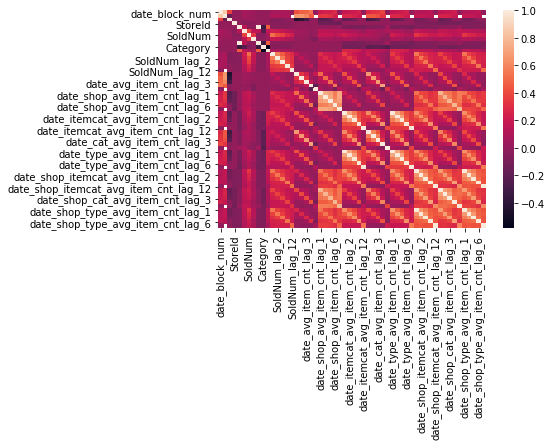

In [18]:
sns.heatmap(matrix_corr)